In [0]:
%python
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# Initialize Spark session
spark = SparkSession.builder.appName("Data Cleaning").getOrCreate()

# Define the schema
schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Study Title", StringType(), True),
    StructField("Acronym", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Conditions", StringType(), True),
    StructField("Interventions", StringType(), True),
    StructField("Sponsor", StringType(), True),
    StructField("Collaborators", StringType(), True),
    StructField("Enrollment", StringType(), True),
    StructField("Funder Type", StringType(), True),
    StructField("Type", StringType(), True),
    StructField("Study Design", StringType(), True),
    StructField("Start", StringType(), True),
    StructField("Completion", StringType(), True),
])

# Load data
file_path = "/FileStore/tables/clinicaltrial_2023/clinicaltrial_2023.csv"
raw_rdd = spark.sparkContext.textFile(file_path)



# Process and clean data
def clean_and_pad(parts):
    # Remove commas, strip quotes and whitespace
    cleaned_parts = [part.replace(",", "").strip().strip('"') for part in parts]
    # Pad the row if it has fewer elements than expected
    if len(cleaned_parts) < 14:
        cleaned_parts += [""] * (14 - len(cleaned_parts))
    return cleaned_parts

processed_rdd = raw_rdd.map(lambda line: line.split("\t")).map(clean_and_pad)


# Filter out the header if it's the first row and matches expected headers
header = processed_rdd.first()  # Assuming the first row is the header
data_rdd = processed_rdd.filter(lambda row: row != header and len(row) == 14)  # Ensure all rows have exactly 14 elements

# Create DataFrame
df = spark.createDataFrame(data_rdd, schema=schema)
df.show()




df.createOrReplaceTempView("clinical_trials")

# Show the cleaned DataFrame
df.show()
    



+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|   Acronym|            Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|NCT03630471|Effectiveness of ...|     PRIDE|         COMPLETED|Mental Health Iss...|BEHAVIORAL: PRIDE...|             Sangath|Harvard Medical S...|     250.0|      OTHER|INTERVENTIONAL|Allocation: RANDO...|2018-08-20|2019-02-28|
|NCT05992571|Oral Ketone Monoe...|          |        RECRUITING|Cerebrovascular 

In [0]:
%python

from pyspark.sql.types import StructType, StructField, StringType, DateType
from pyspark.sql.functions import col, udf, lit
import re
def delete_day(date_str):
    """Removes the day part from a date string (if present) using regular expressions."""
    return re.sub(r'(\b\d(4)-\d(2))-\d(2)\b', r'\1', str(date_str))
def format_date(date_str):
    """Formats a date string (YYYY-MM) into a more human-readable format (Month Year)."""
    if date_str:
        try:
            date_obj = datetime.strptime(date_str, "%Y-%m")
            return date_obj.strftime("%b %Y")
        except ValueError:
            return date_str
    else:
        return date_str
# Define UDFs
delete_day_udf = udf(delete_day, StringType())
format_date_udf = udf(format_date, StringType())
# Apply UDFs in the correct order
df = df.withColumn("Start_Cleaned", delete_day_udf(col("Start")))
df = df.withColumn("Completion_Cleaned", delete_day_udf(col("Completion")))
df = df.withColumn("Start_Date", format_date_udf(col("Start_Cleaned")))
df.withColumn("Completion_Date", format_date_udf(col("Completion_Cleaned")))


Out[23]: DataFrame[Id: string, Study Title: string, Acronym: string, Status: string, Conditions: string, Interventions: string, Sponsor: string, Collaborators: string, Enrollment: string, Funder Type: string, Type: string, Study Design: string, Start: string, Completion: string, Start_Cleaned: string, Completion_Cleaned: string, Start_Date: string, Completion_Date: string]

In [0]:
%python


df = df.drop("Start")
df = df.drop("Completion")
df = df.drop("Start_Date")



In [0]:
#1. The number of studies in the dataset. You must ensure that you explicitly check distinct studies.

In [0]:


# Assuming the first column of your RDD is what you're interested in for distinct counts
distinct_first_elements_count = data_rdd.map(lambda row: row[0]).distinct().count()

print(f"Number of distinct studies: {distinct_first_elements_count}")


Number of distinct studies: 483422


In [0]:
#2. You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. These should be ordered from most frequent to least frequent.

In [0]:
# Extract the "Type" column from the RDD and filter out None values
type_rdd = processed_rdd.map(lambda row: row[10]).filter(lambda x: x is not None)

# Count the occurrences of each type
type_counts_rdd = type_rdd.map(lambda type: (type, 1)).reduceByKey(lambda a, b: a + b)

# Sort the counts in descending order
sorted_type_counts = type_counts_rdd.sortBy(lambda x: x[1], ascending=False)

# Collect the sorted counts
sorted_type_counts_list = sorted_type_counts.collect()

# Print the results
print("{:<30} {:<10}".format('Type', 'Frequency'))
for type, count in sorted_type_counts_list:
    print("{:<30} {:<10}".format(type, count))


Type                           Frequency 
INTERVENTIONAL                 371382    
OBSERVATIONAL                  110221    
EXPANDED_ACCESS                928       
                               891       
Type                           1         


In [0]:
#3. The top 5 conditions (from Conditions) with their frequencies.

In [0]:
# Explode the Conditions column and filter out empty conditions
exploded_rdd = processed_rdd.flatMap(lambda row: 
  # Assuming Conditions is at index 4, check if it's a string before splitting
  [(tuple(cond.split("|")),) for cond in (row[4] or "").split("|") if cond]) \
.filter(lambda x: x[0] != '')

# Count occurrences of each condition
condition_counts = exploded_rdd.map(lambda x: (x[0], 1)) \
                                 .reduceByKey(lambda a, b: a + b)

# Sort by count in descending order and take the top 5
top_5_conditions = condition_counts.sortBy(lambda x: x[1], ascending=False).take(5)

# Print the top 5 conditions and their frequencies
for condition, count in top_5_conditions:
    print(f"Condition: {condition}, Count: {count}")


Condition: ('Healthy',), Count: 9731
Condition: ('Breast Cancer',), Count: 7502
Condition: ('Obesity',), Count: 6549
Condition: ('Stroke',), Count: 4073
Condition: ('Hypertension',), Count: 4022


In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("RDD Example").getOrCreate()
# Define file path
file_path = "/FileStore/tables/pharma/pharma.csv"
# Load the CSV file as an RDD
rdd = spark.sparkContext.textFile(file_path)
# Extract the header
header = rdd.first()
# Split each row by comma
rdd = rdd.map(lambda row: row.split(','))
# Extract the Parent_Company column
parent_companies_rdd = rdd.map(lambda row: (row[1],))  # Assuming Parent_Company is at index 1
# Show the first few rows of the RDD
parent_companies_rdd.take(5)  # You can change 5 to any number to view more or fewer rows


Out[28]: [('"Parent_Company"',),
 ('"Abbott Laboratories"',),
 ('"AbbVie"',),
 ('"AbbVie"',),
 (' Inc."',)]

In [0]:
#4. Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored. Hint: For a basic implementation, you can assume that the Parent Company column contains all possible pharmaceutical companies.

In [0]:
ct_sponsor_col_index = processed_rdd .first().index('Sponsor')

parent_pharm_comp =rdd.map(lambda x: x[1].replace('"', ''))

processed_rdd.map(lambda x: x[ct_sponsor_col_index]).filter(lambda row: row != 'Sponsor').subtract(rdd.map(lambda x: x[1].replace('"', ''))).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False).take(10)

Out[29]: [('National Cancer Institute (NCI)', 3410),
 ('Assiut University', 3335),
 ('Cairo University', 3023),
 ('Assistance Publique - Hôpitaux de Paris', 2951),
 ('Mayo Clinic', 2766),
 ('M.D. Anderson Cancer Center', 2702),
 ('Novartis Pharmaceuticals', 2393),
 ('National Institute of Allergy and Infectious Diseases (NIAID)', 2340),
 ('Massachusetts General Hospital', 2263),
 ('National Taiwan University Hospital', 2181)]

In [0]:
#5. Plot number of completed studies for each month in 2023. You need to include your visualization as well as a table of all the values you have plotted for each month.

In [0]:
from pyspark.sql import Row
# Extract necessary fields assuming indexes: Status - 3, Completion - 13
# Completion date expected format "YYYY-MM"
def extract_fields(row):
    try:
        completion = row[13].split("-")
        year = completion[0] if len(completion) > 0 else None
        month = completion[1] if len(completion) > 1 else None
        status = row[3]
        return (month, year, status)
    except IndexError:
        # Handle the error: you can choose to return None or a default value
        return (None, None, None)

extracted_rdd = data_rdd.map(extract_fields).filter(lambda x: None not in x)

# Filter completed studies and specific year
completed_rdd = extracted_rdd.filter(lambda x: x[2] == "COMPLETED" and x[1] == "2023")

In [0]:


# Count by month
month_counts = completed_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

# Convert the results into a DataFrame
results_rdd = month_counts.map(lambda x: Row(month=int(x[0]), count=x[1])) if month_counts.first()[0].isdigit() \
                               else month_counts.map(lambda x: Row(month=x[0], count=x[1]))
results_df = spark.createDataFrame(results_rdd)
sorted_results_df = results_df.orderBy("month")

# Show the DataFrame as a table
sorted_results_df.show()




+-----+-----+
|month|count|
+-----+-----+
|    1| 1494|
|    2| 1272|
|    3| 1552|
|    4| 1324|
|    5| 1415|
|    6| 1619|
|    7| 1360|
|    8| 1230|
|    9| 1152|
|   10| 1058|
|   11|  909|
|   12| 1082|
+-----+-----+



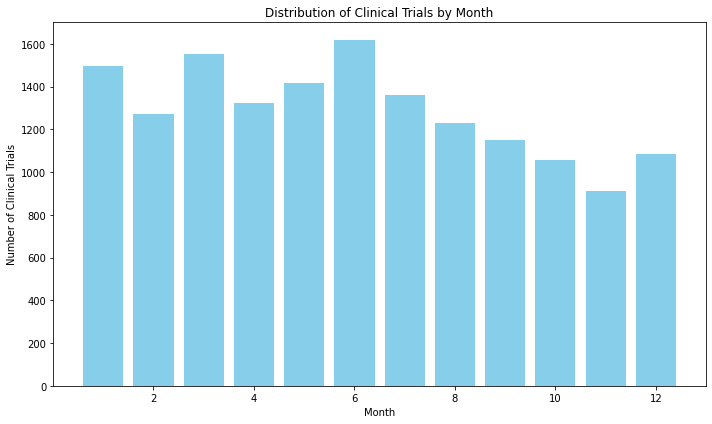

In [0]:
# Plotting (using matplotlib, assumed to be imported)
import matplotlib.pyplot as plt

# Extract month and count from DataFrame
months = [row["month"] for row in sorted_results_df.collect()]  # Collect results as list of dictionaries
counts = [row["count"] for row in sorted_results_df.collect()]

plt.figure(figsize=(10, 6))
plt.bar(months, counts, color='skyblue')
plt.xlabel("Month")
plt.ylabel("Number of Clinical Trials")
plt.title("Distribution of Clinical Trials by Month")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [0]:
# additional analysis Find the number of clinical trials per year of start date
trials_per_year_rdd = data_rdd.map(lambda row: (row[12].split("-")[0], 1)).reduceByKey(lambda a, b: a + b)
trials_per_year_rdd.collect()


Out[33]: [('2023', 33676),
 ('2011', 18321),
 ('2006', 11314),
 ('', 5146),
 ('2022', 34460),
 ('2008', 14924),
 ('1999', 1730),
 ('2001', 2902),
 ('1996', 647),
 ('1984', 44),
 ('1993', 304),
 ('1992', 224),
 ('1979', 16),
 ('2026', 29),
 ('1977', 24),
 ('1988', 95),
 ('1987', 63),
 ('1980', 20),
 ('1976', 19),
 ('2029', 1),
 ('1963', 1),
 ('1968', 1),
 ('2024', 9481),
 ('2010', 17415),
 ('2012', 19380),
 ('2021', 36610),
 ('2004', 7464),
 ('1991', 183),
 ('1997', 868),
 ('1990', 131),
 ('1994', 330),
 ('1983', 36),
 ('1982', 18),
 ('2028', 2),
 ('2100', 5),
 ('1966', 4),
 ('1975', 4),
 ('1973', 5),
 ('2050', 2),
 ('1969', 2),
 ('1974', 2),
 ('1916', 1),
 ('1948', 1),
 ('Start', 1),
 ('2005', 9338),
 ('2017', 27662),
 ('2015', 24205),
 ('1986', 50),
 ('2002', 4117),
 ('2013', 20252),
 ('1995', 505),
 ('1981', 14),
 ('1971', 7),
 ('1978', 21),
 ('2009', 16290),
 ('2019', 31342),
 ('2000', 2301),
 ('2025', 217),
 ('1985', 45),
 ('1964', 1),
 ('1965', 2),
 ('1972', 8),
 ('1970', 2),
 ('1